In [87]:
%reload_ext autoreload
%autoreload 2

import json
import os
import sys
from datetime import datetime
from pathlib import Path
from uuid import uuid4

import boto3
import sagemaker
import torch
import torchvision.models as models
from mypy_boto3_application_autoscaling import ApplicationAutoScalingClient
from mypy_boto3_sagemaker import SageMakerClient
from mypy_boto3_sagemaker_runtime import SageMakerRuntimeClient
from mypy_boto3_sns import SNSClient
from sagemaker import get_execution_role
from sagemaker.image_uris import retrieve
from sagemaker.s3 import S3Uploader
from torchvision.models.detection.mask_rcnn import MaskRCNN_ResNet50_FPN_Weights
from tqdm import tqdm

sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))
from src.helpers import (
    download_prediction,
    read_prediction,
    upload_video,
)

## Infrastucture Overview

<center>
  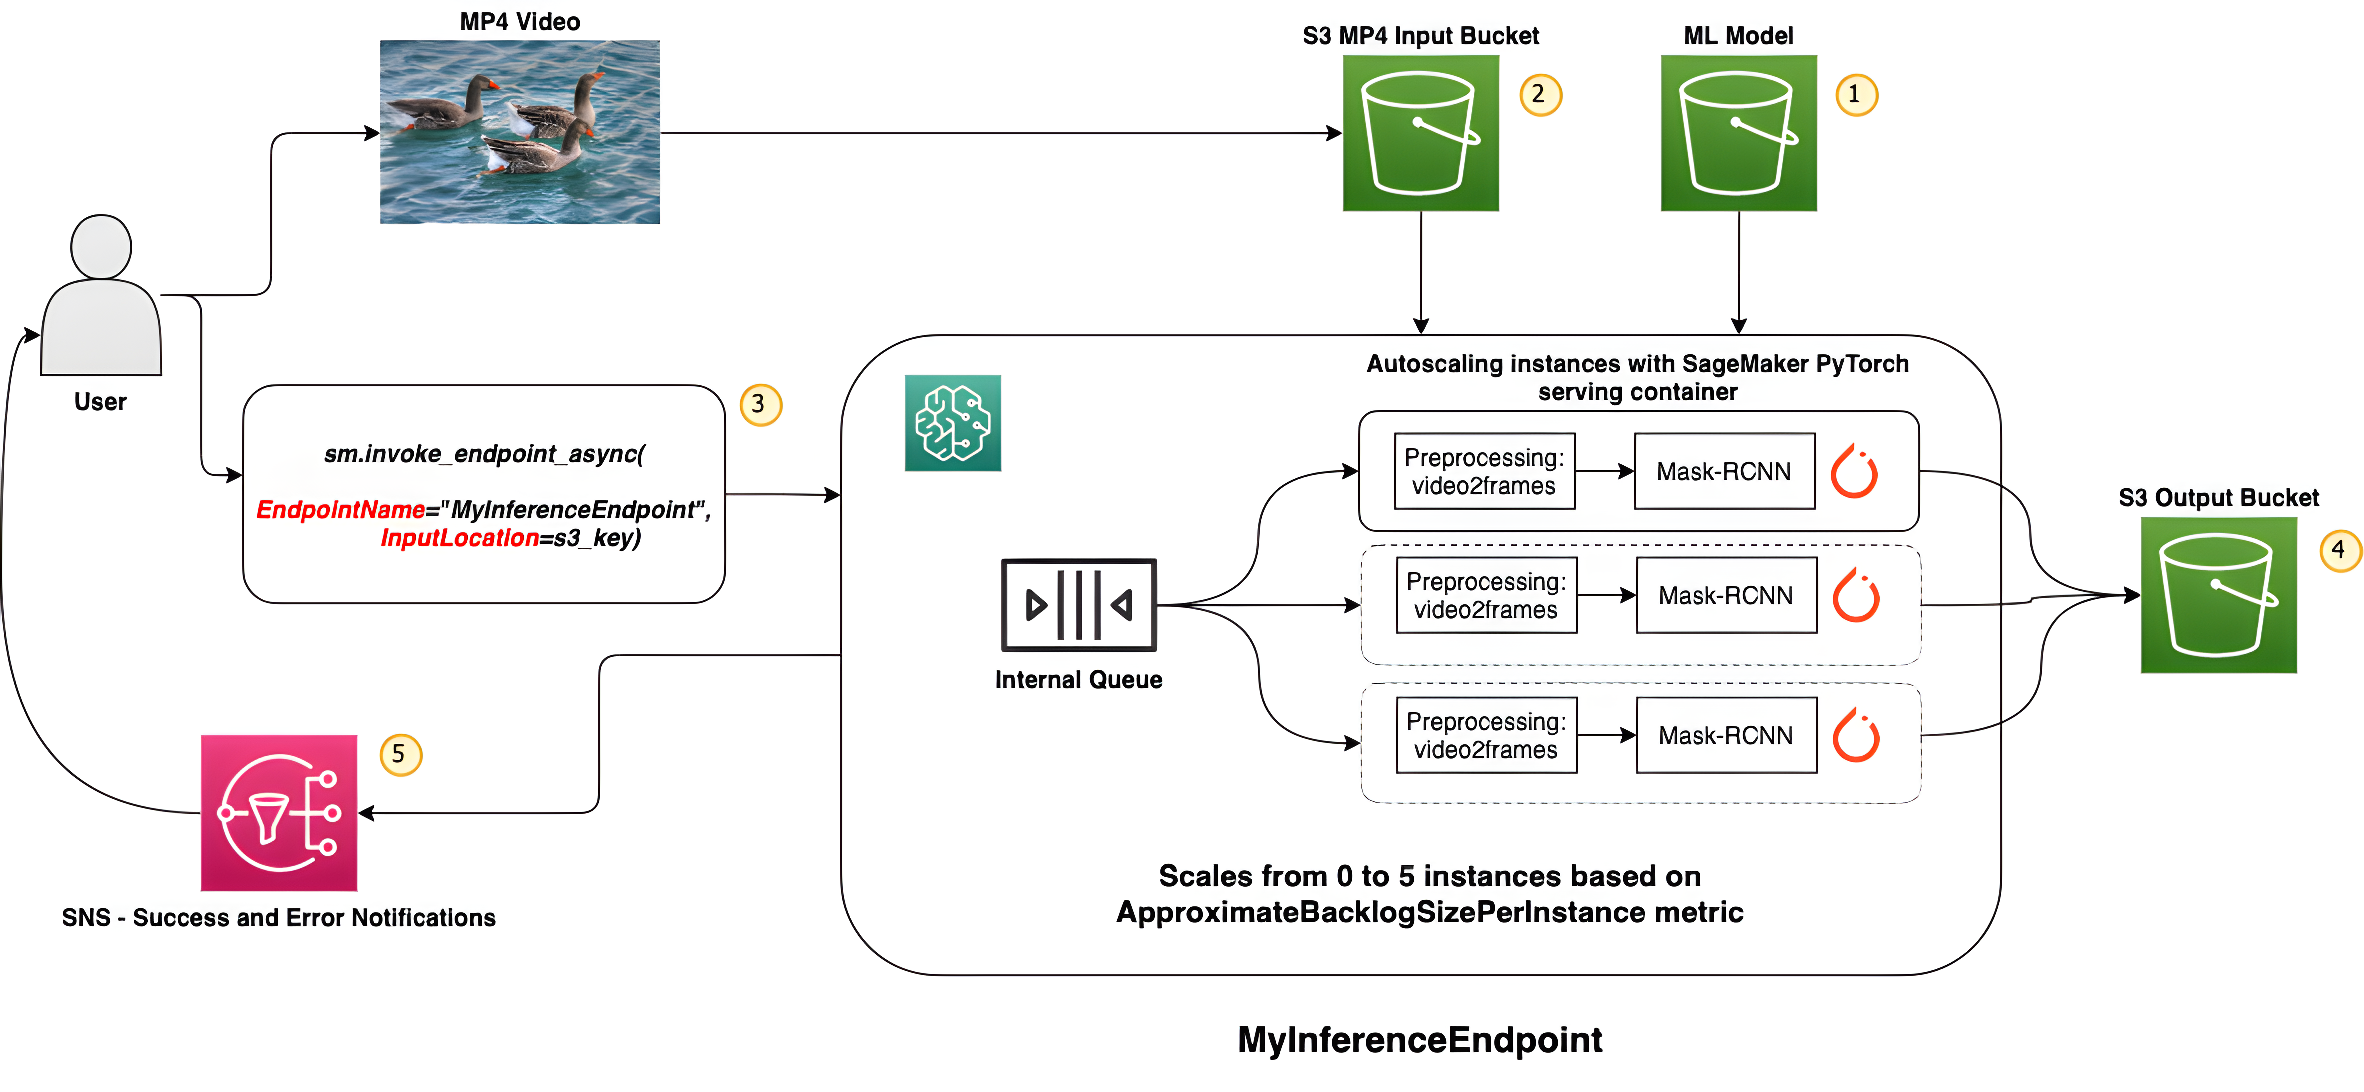
  <figcaption>
    Credit: <a href="https://aws.amazon.com/blogs/machine-learning/run-computer-vision-inference-on-large-videos-with-amazon-sagemaker-asynchronous-endpoints/">Run computer vision inference on large videos with Amazon SageMaker asynchronous endpoints</a>
</center>

## Set Up

### Sessions and Clients

In [ ]:
role = os.getenv("SAGEMAKER_EXECUTION_ROLE_ARN", get_execution_role())
s3_bucket = "async-inference-od-demo"
project_prefix = "async_inference_od_demo"
custom_id = uuid4().hex[:8]
date = datetime.today().strftime("%Y-%m-%d")

# Sessions
profile = os.getenv("AWS_PROFILE", "default")
boto_session = boto3.session.Session(profile_name=profile)
sm_session = sagemaker.session.Session(
    boto_session=boto_session, default_bucket=s3_bucket
)

# Clients
sm_client: SageMakerClient = boto_session.client("sagemaker")
sm_runtime_client: SageMakerRuntimeClient = boto_session.client("sagemaker-runtime")
sns_client: SNSClient = boto_session.client("sns")
autoscaling_client: ApplicationAutoScalingClient = boto_session.client(
    "application-autoscaling"
)

# Constants
region = boto_session.region_name
s3_key_model_data = "model"
s3_key_inference_data = "inference"
path_to_src_dir = "../src"
path_to_sample_video_dir = "../sample_video"

### Parameters

#### Pre-Built Docker Image 

We use a pre-built docker image for model serving:

* Docker image for serving the model: https://github.com/aws/deep-learning-containers/blob/master/available_images.md#sagemaker-framework-containers-sm-support-only

* Instance type: https://saturncloud.io/sagemaker-pricing/

#### Model Entity

Before an endpoint can be created, we first first a sagemaker model entity that references the model artifacts stored on S3:

* Documentation for `sagemaker.model.Model`: https://sagemaker.readthedocs.io/en/stable/api/inference/model.html

* Relevant torch serve environment variables are set in [serve/frontend/server/src/main/java/org/pytorch/serve/util
/ConfigManager.java](https://github.com/pytorch/serve/blob/30f83500b0850e26ec55581f48a9307b1986f9f9/frontend/server/src/main/java/org/pytorch/serve/util/ConfigManager.java#L62) and passed to the Model 


In [64]:
image_params = {
    "instance_type": "ml.g4dn.xlarge",
    "framework": "pytorch",
    "version": "2.5.1",
    "py_version": "py311",
    "image_scope": "inference",
}

model_params = {
    "model_name": f"rcnn-resnet50-{custom_id}",
    "environment_vars": {
        "TS_MAX_REQUEST_SIZE": "100000000",  # Defaults to ~ 6.5 MB -> 100 MB
        "TS_MAX_RESPONSE_SIZE": "100000000",  # Defaults to ~ 6.5 MB -> 100 MB
        "TS_DEFAULT_RESPONSE_TIMEOUT": "1000",  # Defaults to 120s -> 1000s (16.6 minutes)
    },
    "tags": [{"Key": "project", "Value": f"{project_prefix}_model"}],
}

#### SNS Topic

We create two sns topics that sends notifications regarding the status (success/failure) of each inference request:

* What is SNS: https://docs.aws.amazon.com/sns/latest/dg/welcome.html

* Documentation for `boto3.client('sns')`: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sns.html

In [101]:
sns_params = {
    "name_prefix": f"{project_prefix.replace('_', '-')}",
    "tags": [{"Key": "project", "Value": f"{project_prefix}_sns"}],
}

#### SageMaker Endpoint Configurations and Endpoint

* Documentation for asynchronous endpoint: https://docs.aws.amazon.com/sagemaker/latest/dg/async-inference.html

* Documentation for endpoint configuration: https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateEndpointConfig.html

* Documentation for `boto3.client('sagemaker').create_endpoint_config()`: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.create_endpoint_config

* Documentation for `boto3.client('sagemaker').create_endpoint()`: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker/client/create_endpoint.html

In [66]:
endpoint_config_params = {
    "endpoint_config_name": f"{project_prefix.replace('_', '-')}-endpoint-config-{custom_id}",
    "production_variants": {
        "variant_name": f"variant-{date}",
        "model_name": model_params["model_name"],
        "initial_instance_count": 1,
        "instance_type": image_params["instance_type"],
        "container_startup_health_check_timeout_in_seconds": 360,
    },
    "async_inference_config": {
        "output_config": {
            "s3_output_path": f"s3://{s3_bucket}/{s3_key_inference_data}/output",
            "notification_config": {
                "s3_failure_path": f"s3://{s3_bucket}/{s3_key_inference_data}/failure",
            },
        },
        "client_config": {
            "max_concurrent_invocations_per_instance": 2,
        },
    },
    "tags": [{"Key": "project", "Value": f"{project_prefix}_endpoint_config"}],
}

endpoint_params = {
    "endpoint_name": f"{project_prefix.replace('_', '-')}-endpoint-{custom_id}",
    "endpoint_config_name": endpoint_config_params["endpoint_config_name"],
    "tags": [{"Key": "project", "Value": f"{project_prefix}_endpoint"}],
}

#### Invocation

* Documentation for `boto3.client('sagemaker-runtime').invoke_endpoint()`: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker-runtime.html#SageMakerRuntime.Client.invoke_endpoint

* Common data formats for inference: https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-inference.html#cm-batch

In [67]:
invoke_endpoint_async_params = {
    "endpoint_name": endpoint_params["endpoint_name"],
    "content_type": "video/mp4",  # Input mimetype
    "accept": "application/json",  # Output mimetype
    "request_ttl_seconds": 60 * 60 * 3,  # 3 hours
    "invocation_timeout_seconds": 900,  # 15 minutes
}

#### Autoscaling

* Application auto scaling concepts: https://docs.aws.amazon.com/autoscaling/application/userguide/getting-started.html

* Documentation for autoscaling an asynchronous endpoint: https://docs.aws.amazon.com/sagemaker/latest/dg/async-inference-autoscale.html

* Documentation for `boto3.client('application-autoscaling').register_scalable_target()`: https://boto3.amazonaws.com/v1/documentation/api/1.35.9/reference/services/application-autoscaling/client/register_scalable_target.html

* Documentation for `boto3.client('application-autoscaling').put_scaling_policy`: https://boto3.amazonaws.com/v1/documentation/api/1.35.9/reference/services/application-autoscaling/client/put_scaling_policy.html

In [68]:
register_scalable_target_params = {
    "service_namespace": "sagemaker",
    "resource_id": f"endpoint/{endpoint_params['endpoint_name']}/variant/{endpoint_config_params['production_variants']['variant_name']}",
    "scalable_dimension": "sagemaker:variant:DesiredInstanceCount",
    "min_capacity": 0,
    "max_capacity": 5,
    "tags": {"Key": "project", "Value": f"{project_prefix}_autoscaling"},
}

put_scaling_policy_params = {
    "policy_name": f"{project_prefix.replace('_', '-')}-scaling-policy-{custom_id}",
    "service_namespace": register_scalable_target_params["service_namespace"],
    "resource_id": register_scalable_target_params["resource_id"],
    "scalable_dimension": register_scalable_target_params["scalable_dimension"],
    "policy_type": "TargetTrackingScaling",
    "target_tracking_scaling_policy_configuration": {
        "target_value": 5.0,  # Target instance count
        "customized_metric_specification": {
            "metric_name": "ApproximateBacklogSizePerInstance",
            "namespace": "AWS/SageMaker",
            "dimensions": [
                {"Name": "EndpointName", "Value": endpoint_params["endpoint_name"]},
            ],
            "statistic": "Average",
        },
        "scale_in_cooldown": 120,  # Amount of time in seconds after a scale-in activity completes before another scale-in activity can start
        "scale_out_cooldown": 120,  # Amount of time in seconds to wait for a previous scale-out activity to take effect
    },
}

## Pretrained Model: Mask R-CNN with ResNet-50-FPN

The [maskrcnn_resnet50_fpn](https://pytorch.org/vision/main/models/mask_rcnn.html) model integrates **Mask R-CNN** with a **ResNet-50 backbone** and **Feature Pyramid Network (FPN)** for advanced object detection and segmentation tasks.

### Key Features

- **Input Requirements**: A list of tensors, each `[C, H, W]` with pixel values in the 0-1 range. Image sizes can vary.

- **Inference Outputs**:
  - **`boxes`** (`FloatTensor[N, 4]`): Predicted bounding boxes in `[x1, y1, x2, y2]` format.
  - **`labels`** (`Int64Tensor[N]`): Predicted class labels.
  - **`scores`** (`Tensor[N]`): Confidence scores for each detection.
  - **`masks`** (`UInt8Tensor[N, 1, H, W]`): Segmentation masks in the 0-1 range (threshold with `mask >= 0.5` for binary masks).

In [69]:
model = models.detection.maskrcnn_resnet50_fpn(
    weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1
)
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

### Archive and Upload to S3

We won't be doing any fine-tuning but simply upload the downloaded pre-trained model weights to s3:

In [ ]:
!mkdir -p model/code
torch.save(model.state_dict(), "model/model.pth")
!rsync -av --exclude='__pycache__' --exclude='helpers.py' $path_to_src_dir/ model/code/
!tar --exclude="__pycache__" -czvf model.tar.gz -C model/ .
!rm -rf model

In [72]:
model_artifact_s3_uri = S3Uploader.upload(
    local_path="model.tar.gz",
    desired_s3_uri=f"s3://{s3_bucket}/{s3_key_model_data}",
    sagemaker_session=sm_session,
)

!rm model.tar.gz

model_artifact_s3_uri

's3://async-inference-od-demo/model/model.tar.gz'

## Model Entity

Use a pre-built [docker container](https://github.com/aws/deep-learning-containers/blob/master/available_images.md#ec2-framework-containers-tested-on-ec2-ecs-and-eks-only) already setup with pytorch, torch serve, and torchvision. Any additional dependencies can be specified in `src/requirements.txt`, which is packaged with the model artifacts.

In [ ]:
inference_image_uri = retrieve(
    framework=image_params["framework"],
    region=region,
    version=image_params["version"],
    py_version=image_params["py_version"],
    instance_type=image_params["instance_type"],
    image_scope=image_params["image_scope"],
    sagemaker_session=sm_session,
)

inference_image_uri

For more on torchserver configurations: https://pytorch.org/serve/configuration.html

In [ ]:
model_response = sm_client.create_model(
    ModelName=model_params["model_name"],
    PrimaryContainer={
        "Image": inference_image_uri,
        "ModelDataUrl": model_artifact_s3_uri,
        "Environment": model_params["environment_vars"],
    },
    ExecutionRoleArn=role,
    Tags=model_params["tags"],
)

model_response["ModelArn"]

## Asynchronous Inference Endpoint

### SNS Topics

Create SNS topics to publish inference results--- success or failure.

> If terraform is used to create the sagemaker execution role, ensure that its SNS policy references the correct ARN's that match the `Name`'s of the topics created below.

In [ ]:
sns_responses = {
    status: sns_client.create_topic(
        Name=f"{sns_params['name_prefix']}-{status}", Tags=sns_params["tags"]
    )
    for status in ["success", "failure"]
}

sns_responses["success"]["TopicArn"], sns_responses["failure"]["TopicArn"]

### Endpoint Configurations

Create the endpoint configuration:

In [ ]:
endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_params["endpoint_config_name"],
    ProductionVariants=[
        {
            "VariantName": endpoint_config_params["production_variants"][
                "variant_name"
            ],
            "ModelName": endpoint_config_params["production_variants"]["model_name"],
            "InstanceType": endpoint_config_params["production_variants"][
                "instance_type"
            ],
            "InitialInstanceCount": endpoint_config_params["production_variants"][
                "initial_instance_count"
            ],
            "ContainerStartupHealthCheckTimeoutInSeconds": endpoint_config_params[
                "production_variants"
            ]["container_startup_health_check_timeout_in_seconds"],
        }
    ],
    AsyncInferenceConfig={
        "OutputConfig": {
            "S3OutputPath": endpoint_config_params["async_inference_config"][
                "output_config"
            ]["s3_output_path"],
            "NotificationConfig": {
                "SuccessTopic": sns_responses["success"]["TopicArn"],
                "ErrorTopic": sns_responses["failure"]["TopicArn"],
            },
            "S3FailurePath": endpoint_config_params["async_inference_config"][
                "output_config"
            ]["notification_config"]["s3_failure_path"],
        },
        "ClientConfig": {
            "MaxConcurrentInvocationsPerInstance": endpoint_config_params[
                "async_inference_config"
            ]["client_config"]["max_concurrent_invocations_per_instance"],
        },
    },
    Tags=endpoint_config_params["tags"],
)

endpoint_config_response["EndpointConfigArn"]

### Endpoint

Create the endpoint:

In [ ]:
endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_params["endpoint_name"],
    EndpointConfigName=endpoint_params["endpoint_config_name"],
    Tags=endpoint_params["tags"],
)

endpoint_response["EndpointArn"]

We'll use a [waiter](https://boto3.amazonaws.com/v1/documentation/api/latest/guide/clients.html#waiters) to poll the status of the endpoint creation and block until it's successfully created:

In [107]:
endpoint_waiter = sm_client.get_waiter("endpoint_in_service")
print("Waiting for endpoint to be in service...")
endpoint_waiter.wait(EndpointName=endpoint_params["endpoint_name"])
describe_endpoint_response = sm_client.describe_endpoint(
    EndpointName=endpoint_params["endpoint_name"]
)
print(f"Endpoint status: {describe_endpoint_response['EndpointStatus']}")

Waiting for endpoint to be in service...
Endpoint status: InService


## Upload Sample Video

**Note:** The max size of each payload is 100 MB set by `TS_MAX_REQUEST_SIZE`:

In [ ]:
for video_path in Path(path_to_sample_video_dir).rglob("*.mp4"):
    video_s3_uri = upload_video(
        sm_session, video_path, s3_bucket, s3_key_inference_data
    )
    print(f"Uploaded video to {video_s3_uri}")

## Test Inference Endpoint

### Single Request

In [ ]:
single_request_response = sm_runtime_client.invoke_endpoint_async(
    EndpointName=invoke_endpoint_async_params["endpoint_name"],
    ContentType=invoke_endpoint_async_params["content_type"],
    Accept=invoke_endpoint_async_params["accept"],
    InferenceId=f"single-request-{custom_id}-{date}",
    InputLocation=video_s3_uri,
    RequestTTLSeconds=invoke_endpoint_async_params["request_ttl_seconds"],
    InvocationTimeoutSeconds=invoke_endpoint_async_params["invocation_timeout_seconds"],
)

single_request_response["OutputLocation"]

In [110]:
single_request_predictions = json.loads(
    read_prediction(sm_session, single_request_response["OutputLocation"])
)
single_request_predictions[0]["scores"][:10]

[0.9804738759994507,
 0.9782150983810425,
 0.9500901103019714,
 0.9392717480659485,
 0.9389567971229553,
 0.9022442698478699,
 0.8906528949737549,
 0.8893300890922546,
 0.8743063807487488,
 0.8612176775932312]

Download the output file:

In [113]:
download_prediction(
    sm_session, single_request_response["OutputLocation"], path_to_sample_video_dir
)

Rename the `*.out` file:

In [114]:
json_file_name = "boxes.json"

!mv {path_to_sample_video_dir}/*.out {path_to_sample_video_dir}/{json_file_name}

Generate the gif:

In [ ]:
!python3 {path_to_src_dir}/generate_gif.py \
    --video_path {path_to_sample_video_dir}/traffic.mp4 \
    --predictions_path {path_to_sample_video_dir}/{json_file_name} \
    --output_path {path_to_sample_video_dir}/annotated_frames

## Autoscaling (Optinal)

### Register Scalalbe Target

In [ ]:
register_scalalbe_target_response = autoscaling_client.register_scalable_target(
    ServiceNamespace=register_scalable_target_params["service_namespace"],
    ResourceId=register_scalable_target_params["resource_id"],
    ScalableDimension=register_scalable_target_params["scalable_dimension"],
    MinCapacity=register_scalable_target_params["min_capacity"],
    MaxCapacity=register_scalable_target_params["max_capacity"],
    RoleARN=role,
    Tags=register_scalable_target_params["tags"],
)

register_scalalbe_target_response["ScalableTargetARN"]

### Scaling Policy

In [ ]:
put_scaling_policy_response = autoscaling_client.put_scaling_policy(
    PolicyName=put_scaling_policy_params["policy_name"],
    ServiceNamespace=put_scaling_policy_params["service_namespace"],
    ResourceId=put_scaling_policy_params["resource_id"],
    ScalableDimension=put_scaling_policy_params["scalable_dimension"],
    PolicyType=put_scaling_policy_params["policy_type"],
    TargetTrackingScalingPolicyConfiguration={
        "TargetValue": put_scaling_policy_params[
            "target_tracking_scaling_policy_configuration"
        ]["target_value"],
        "CustomizedMetricSpecification": {
            "MetricName": put_scaling_policy_params[
                "target_tracking_scaling_policy_configuration"
            ]["customized_metric_specification"]["metric_name"],
            "Namespace": put_scaling_policy_params[
                "target_tracking_scaling_policy_configuration"
            ]["customized_metric_specification"]["namespace"],
            "Dimensions": put_scaling_policy_params[
                "target_tracking_scaling_policy_configuration"
            ]["customized_metric_specification"]["dimensions"],
            "Statistic": put_scaling_policy_params[
                "target_tracking_scaling_policy_configuration"
            ]["customized_metric_specification"]["statistic"],
        },
        "ScaleInCooldown": put_scaling_policy_params[
            "target_tracking_scaling_policy_configuration"
        ]["scale_in_cooldown"],
        "ScaleOutCooldown": put_scaling_policy_params[
            "target_tracking_scaling_policy_configuration"
        ]["scale_out_cooldown"],
    },
)

put_scaling_policy_response["PolicyARN"]

Trigger 100 asynchronous inference requests to test the endpoint's autoscaling capabilities:

In [ ]:
num_invocations = 100

for i in tqdm(range(1, num_invocations + 1)):
    sm_runtime_client.invoke_endpoint_async(
        EndpointName=invoke_endpoint_async_params["endpoint_name"],
        ContentType=invoke_endpoint_async_params["content_type"],
        Accept=invoke_endpoint_async_params["accept"],
        InferenceId=f"async-request-{custom_id}-{date}-{i}",
        InputLocation=video_s3_uri,
        RequestTTLSeconds=invoke_endpoint_async_params["request_ttl_seconds"],
        InvocationTimeoutSeconds=invoke_endpoint_async_params[
            "invocation_timeout_seconds"
        ],
    )

**Note:** Scaling events may take some time to fully complete after being triggered. 

1. **Scale-Out Trigger**  

   The system initiates a scale-out event when the metric `ApproximateBacklogSizePerInstance` exceeds **5** for **3 consecutive data points**, each recorded at **1-minute intervals**, over a total duration of **3 minutes**.  
   - Upon triggering, the number of instances will scale out to the defined maximum capacity (`max_capacity`) of **5 instances** if the backlog size per instance remains above this threshold.

2. **Scale-In Trigger**  

   The system initiates a scale-in event when the metric `ApproximateBacklogSizePerInstance` drops below **4.5** for **15 consecutive data points**, each recorded at **1-minute intervals**, over a total duration of **15 minutes**.  
   - Upon triggering, the number of instances will scale down to the defined minimum capacity (`min_capacity`) of **0 instances**, provided all requests have been completed and the backlog size per instance remains below the threshold.

#### Scale Out

Check auto-scaling activites for scale out using the AWS CLI:

In [52]:
!aws application-autoscaling describe-scaling-activities \
    --profile {profile} \
    --service-namespace {register_scalable_target_params['service_namespace']} \
    --resource-id endpoint/{endpoint_params['endpoint_name']}/variant/{endpoint_config_params['production_variants']['variant_name']} \
    --scalable-dimension {register_scalable_target_params['scalable_dimension']} 

{
    "ScalingActivities": [
        {
            "ActivityId": "71a7d099-43ed-4239-b88b-51a484c34ea8",
            "ServiceNamespace": "sagemaker",
            "ResourceId": "endpoint/async-inference-demo-endpoint-697e5488/variant/variant-2024-12-19",
            "ScalableDimension": "sagemaker:variant:DesiredInstanceCount",
            "Description": "Setting desired instance count to 5.",
            "Cause": "monitor alarm TargetTracking-endpoint/async-inference-demo-endpoint-697e5488/variant/variant-2024-12-19-AlarmHigh-88be3cc9-80aa-48dd-a95b-e32e8a69547b in state ALARM triggered policy async-inference-demo-scaling-policy-697e5488",
            "StartTime": "2024-12-19T20:06:40.008000-05:00",
            "EndTime": "2024-12-19T20:13:19.868000-05:00",
            "StatusCode": "Successful",
            "StatusMessage": "Successfully set desired instance count to 5. Change successfully fulfilled by sagemaker."
        }
    ]
}


> Alternatively, check the sagemaker console `Inference -> Endpoints -> async-inference-demo-endpoint-custom-id -> Settings -> Endpoint runtime settings` to see the autoscaling activities take place.

<center>
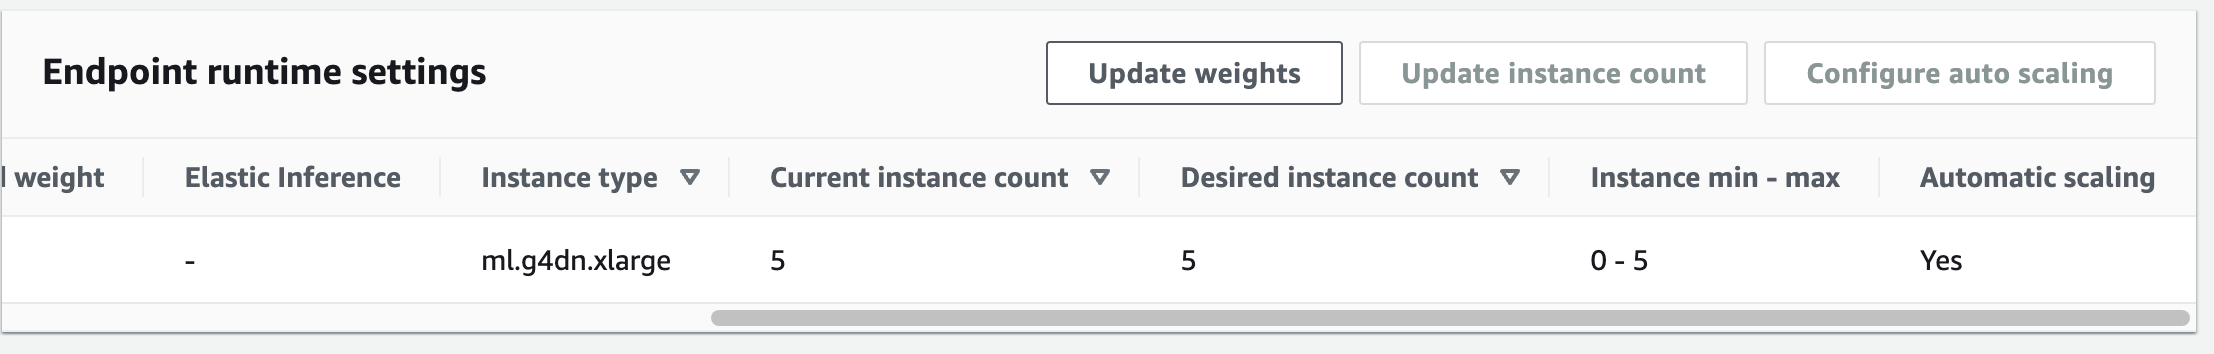

</center>

##### Metric for Scale Out

<center>
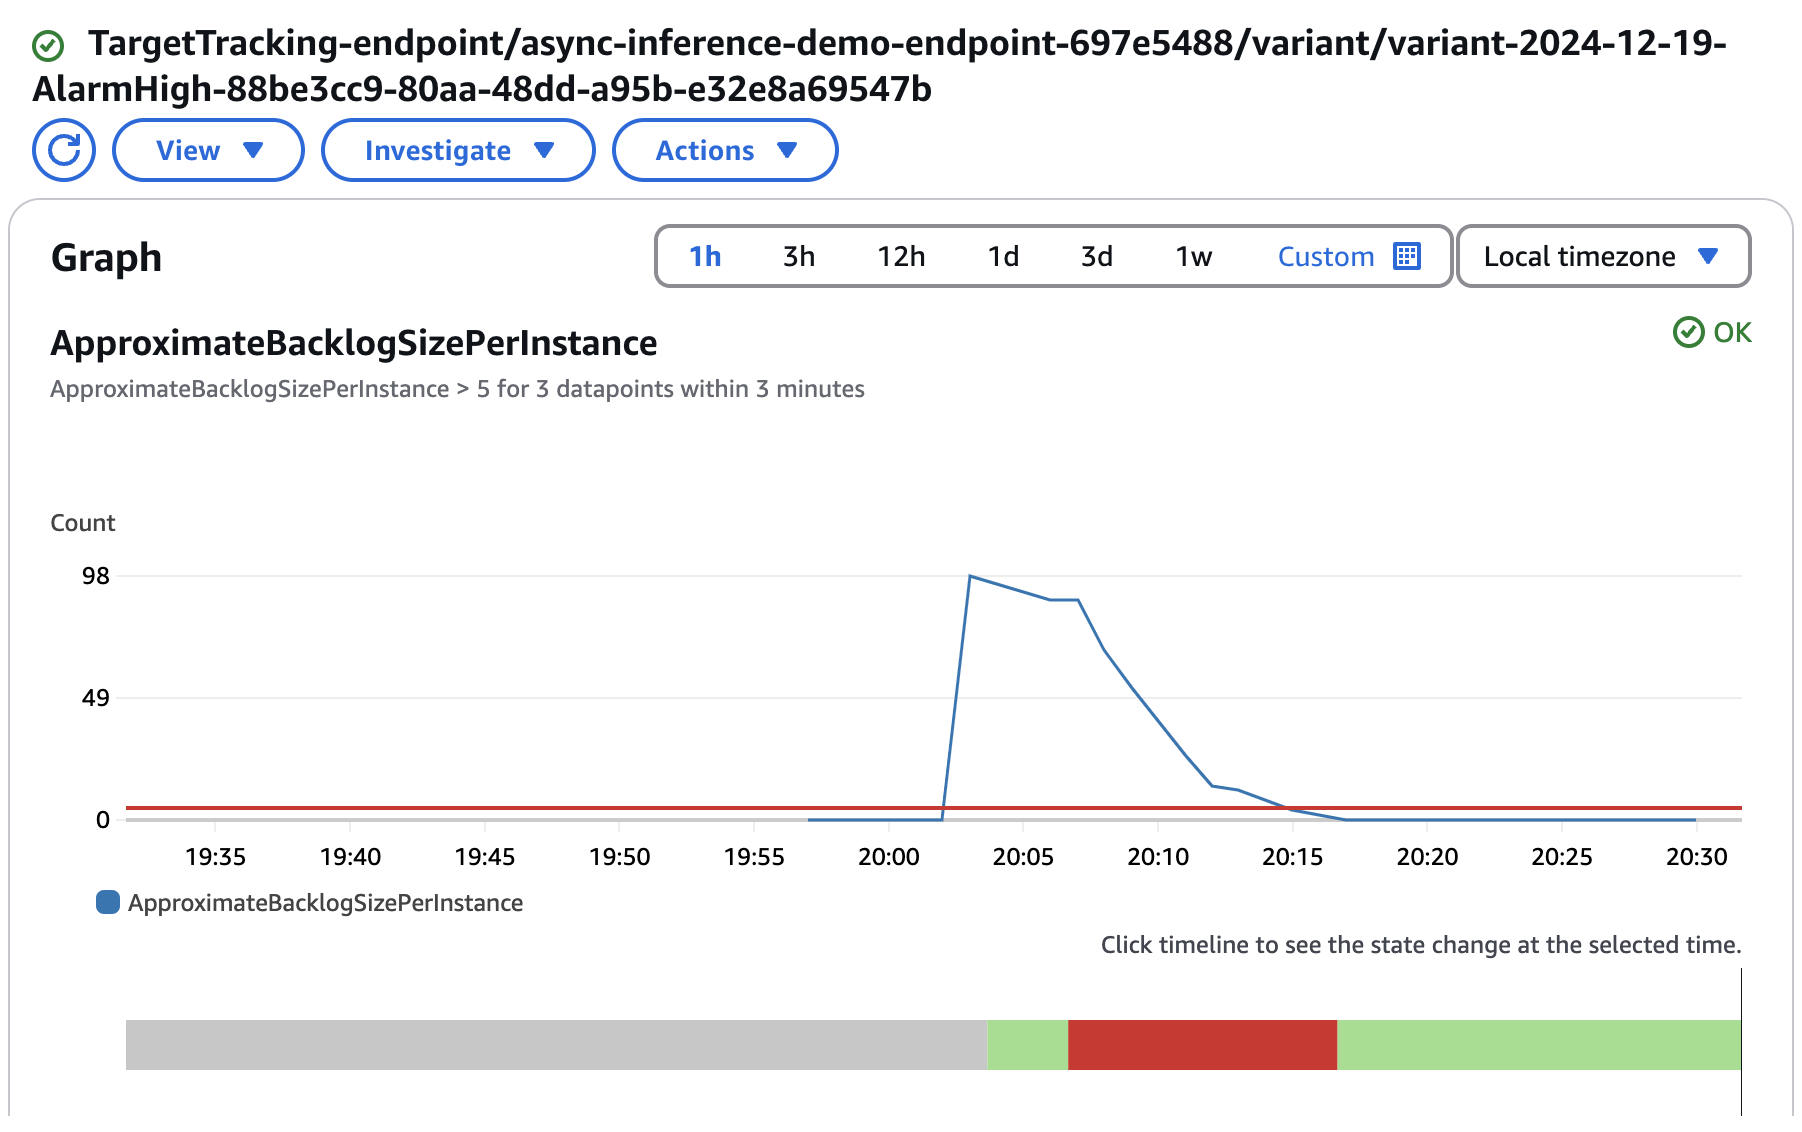
</center>

#### Scale In

After all requests have been completed, a scale-in activity will not be triggered immediately. The system requires **15 consecutive datapoints** of `ApproximateBacklogSizePerInstance` being **< 4.5** requests, recorded at **1-minute intervals** over a period of **15 minutes**, to initiate a scale-in event:

In [18]:
!aws application-autoscaling describe-scaling-activities \
    --profile {profile} \
    --service-namespace {register_scalable_target_params['service_namespace']} \
    --resource-id endpoint/{endpoint_params['endpoint_name']}/variant/{endpoint_config_params['production_variants']['variant_name']} \
    --scalable-dimension {register_scalable_target_params['scalable_dimension']} 

{
    "ScalingActivities": [
        {
            "ActivityId": "d7c7dcc1-5887-4a22-a420-325771d705c8",
            "ServiceNamespace": "sagemaker",
            "ResourceId": "endpoint/async-inference-demo-endpoint-697e5488/variant/variant-2024-12-19",
            "ScalableDimension": "sagemaker:variant:DesiredInstanceCount",
            "Description": "Setting desired instance count to 0.",
            "Cause": "monitor alarm TargetTracking-endpoint/async-inference-demo-endpoint-697e5488/variant/variant-2024-12-19-AlarmLow-0690ab57-2ba6-40d5-b6a9-595655c7a22a in state ALARM triggered policy async-inference-demo-scaling-policy-697e5488",
            "StartTime": "2024-12-19T20:43:50.014000-05:00",
            "EndTime": "2024-12-19T20:44:20.956000-05:00",
            "StatusCode": "Successful",
            "StatusMessage": "Successfully set desired instance count to 0. Change successfully fulfilled by sagemaker."
        },
        {
            "ActivityId": "2683cd3f-64d0-4cf8-8748-

After ~15 minutes, we should see that the count of instances has been scaled in down to 0.

<center>
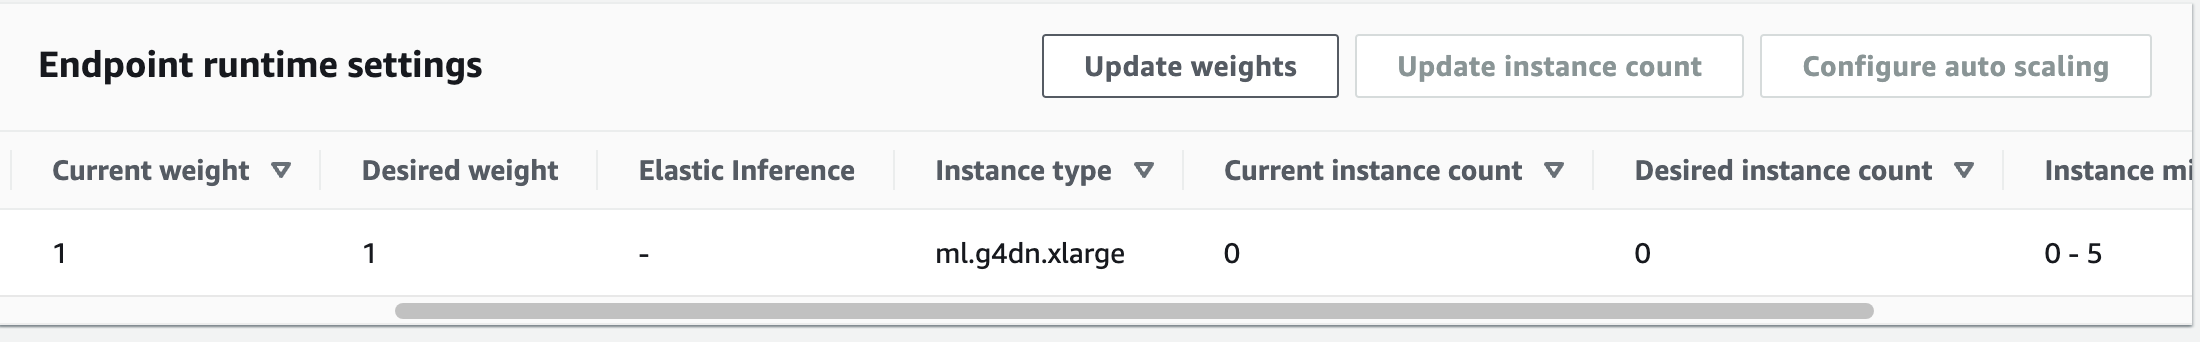
</center>

## Clean Up

### SageMaker

In [120]:
deregister_scalable_target_response = autoscaling_client.deregister_scalable_target(
    ServiceNamespace=register_scalable_target_params["service_namespace"],
    ResourceId=register_scalable_target_params["resource_id"],
    ScalableDimension=register_scalable_target_params["scalable_dimension"],
)

deregister_scalable_target_response

{'ResponseMetadata': {'RequestId': '0431cf32-7dbc-4b9a-a019-c5752b12e706',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '0431cf32-7dbc-4b9a-a019-c5752b12e706',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'date': 'Fri, 20 Dec 2024 03:41:56 GMT'},
  'RetryAttempts': 0}}

In [121]:
sm_client.delete_endpoint_config(
    EndpointConfigName=endpoint_config_params["endpoint_config_name"]
)
sm_client.delete_endpoint(EndpointName=endpoint_params["endpoint_name"])
sm_client.delete_model(ModelName=model_params["model_name"])

{'ResponseMetadata': {'RequestId': 'c3401fed-4917-4cd4-88c5-92b1c0a7267f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c3401fed-4917-4cd4-88c5-92b1c0a7267f',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 20 Dec 2024 03:41:58 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}

### SNS

In [122]:
sns_client.delete_topic(TopicArn=sns_responses["success"]["TopicArn"])
sns_client.delete_topic(TopicArn=sns_responses["failure"]["TopicArn"])

{'ResponseMetadata': {'RequestId': 'a57f5045-070a-5e63-8cf5-0f9beec253e5',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'a57f5045-070a-5e63-8cf5-0f9beec253e5',
   'date': 'Fri, 20 Dec 2024 03:42:00 GMT',
   'content-type': 'text/xml',
   'content-length': '201',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

### S3

In [123]:
!aws s3 rm --recursive s3://{s3_bucket}/{s3_key_model_data} --quiet

In [124]:
!aws s3 rm --recursive s3://{s3_bucket}/{s3_key_inference_data} --quiet

Delete the S3 bucket using terraform or via the UI.

## Clients

In [125]:
for client in [sm_client, sm_runtime_client, autoscaling_client, sns_client]:
    print(client.meta.service_model.service_name)
    client.close()

sagemaker
sagemaker-runtime
application-autoscaling
sns
